In [5]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path
%matplotlib inline
def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims
from skimage.measure import regionprops

In [6]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed Culture/STEDBIN/'
protein="TNR" #TNR,Agg,WFA,HABP

In [7]:
results = {"filename":[],
          "exp condition":[],
          "ecmchannelno":[],
          "synapsechannelno":[],
           "Manual vglut spots mask":[]
          }
           
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if "_analyse" in str(filelist[i]):
        #print(1)
        if "2019" in str(filelist[i]):
            #print(2)
            if ("Pop" in str(filelist[i]))==False:
                #print(3)
                if ("save" in str(filelist[i]))==False:
                    #print(4)
                    if ("ilvio" in str(filelist[i]))==False:
                        if ("spot" in str(filelist[i]))==False:
                            if ("TIFs_analyse copy" in str(filelist[i]))==False:
                                if ("samecellonly" in str(filelist[i]))==False:
                            
                            #print(5)
                                    if filelist[i].endswith(".tif"): 
                                    #print(6)
                                        if "\\" in str(filelist[i]):
                                            #print(7)
                                            if (('/').join(filelist[i].split('\\')[:-1])+'\\\\'+filelist[i][:-12].split('\\')[-1] in str(results["filename"]))==False:
                                                print(filelist[i])
                                                results["filename"].append(filelist[i][:-12])
                                                results["exp condition"].append(filelist[i][:-12].split('/')[-2])
                                                channeldir="/".join(filelist[i][:-12].split("/")[:-2])
                                                exec(open(channeldir+"/channels.txt").read())
                                                results["ecmchannelno"].append(ecmchannelno)
                                                results["synapsechannelno"].append(synapsechannelno) 
                                        elif (str(filelist[i][:-12]) not in str(results["filename"]))==True:
                                            print(8)
                                            results["filename"].append(filelist[i][:-12])
                                            results["exp condition"].append(filelist[i][:-12].split('/')[-2])
                                            channeldir="/".join(filelist[i][:-12].split("/")[:-2])
                                            exec(open(channeldir+"/channels.txt").read())
                                            results["ecmchannelno"].append(ecmchannelno)
                                            results["synapsechannelno"].append(synapsechannelno)

/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed Culture/STEDBIN/20190216_TNR580_DiO_VGlut647/TIFs_analyse/12hr_Bic/TIF_imp\05_001_ExpControl Ch1 {0}.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed Culture/STEDBIN/20190216_TNR580_DiO_VGlut647/TIFs_analyse/12hr_Bic/TIF_imp\05_002_ExpControl Ch1 {0}.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed Culture/STEDBIN/20190216_TNR580_DiO_VGlut647/TIFs_analyse/12hr_Bic/TIF_imp\05_004_ExpControl Ch1 {0}.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed Culture/STEDBIN/20190216_TNR580_DiO_VGlut647/TIFs_analyse/12hr_Bic/TIF_imp\05_005_ExpControl Ch1 {0}.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed Culture/STEDBIN/20190216_TNR580_DiO_VGlut647/TIFs_analyse/12hr_Bic/TIF_imp\06_001_ExpControl Ch1 {0}.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed Culture/STEDBIN/20190216_TNR580_DiO_VGlut647/TIFs_analyse/12hr_Bic/TIF_imp\06_002_ExpControl Ch1 {0}.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed Culture/STEDB

## load random image

Image name: 03_cell1_dendrite_ExpControl
Experimental condition: TIF_imp


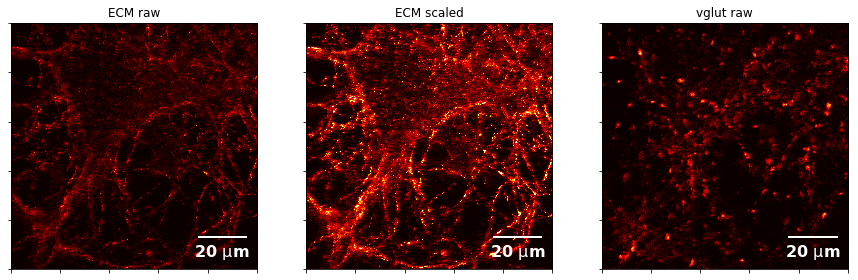

In [8]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
synapse_channel_no=results["synapsechannelno"][randomno]

ecm_image_name=results["filename"][randomno]+" Ch"+str(ecm_channel_no)+" {0}.tif"
synapse_image_name=results["filename"][randomno]+" Ch"+str(synapse_channel_no)+" {0}.tif"

print("Image name:",results["filename"][randomno].split('/')[-1])
print("Experimental condition:",results["exp condition"][randomno])
ecm_image=pims.open(ecm_image_name)[0]
synapse_image=pims.open(synapse_image_name)[0]
#autofluorescence_image=pims.open(autofluorescence_image_name)[0]

figure=plt.figure(figsize=(15,15))
figure.add_subplot(131)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
figure.add_subplot(132)
plt.imshow(ecm_image,interpolation='none',cmap='hot',vmin=3*np.min(ecm_image),vmax=0.4*np.max(ecm_image))
plt.title('ECM scaled')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

figure.add_subplot(133)
plt.imshow(synapse_image,interpolation='none',cmap='hot')
plt.title('vglut raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

## load synapse spots

In [9]:
for image in range(0,len(results["filename"])):
    results["Manual vglut spots mask"].append(np.load(results["filename"][image]+'_vglut_spots_mask.npy'))

## Sanity check

24


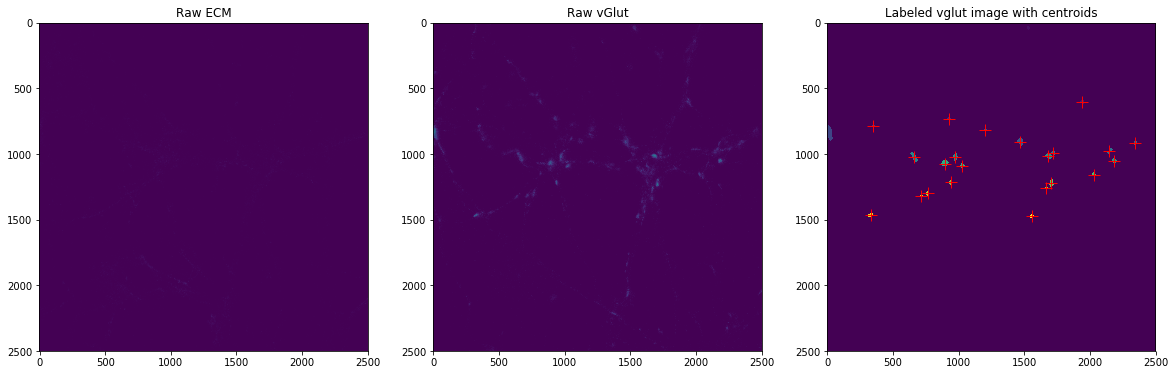

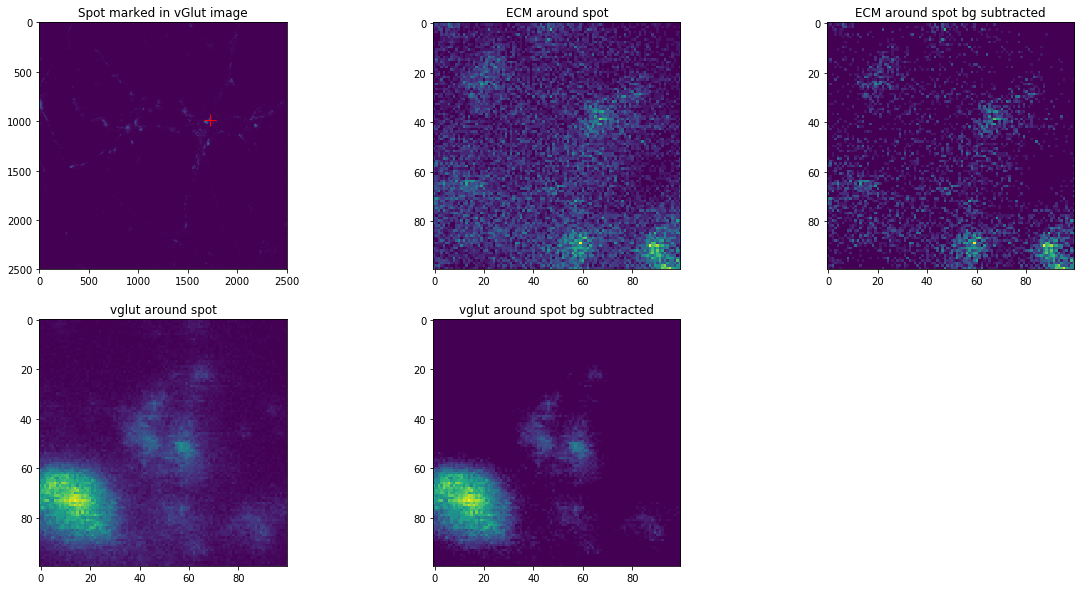

In [11]:
randomno=np.random.randint(1,len(results["filename"]))


ecm_distribution_around_synapses={"filename":[],
                                  "exp condition":[],
                                  "ecm_around_single_spot":[],
                                  "ecm_around_single_spot_mean_intensity":[],
                                  "original_synapse_at_single_spot":[],
                                  "mean_intensty_original_synapse":[],
                                  "ecm_around_single_spot bg subtracted":[],
                                  "ecm_around_single_spot_mean_intensity bg subtracted":[],
                                  "original_synapse_at_single_spot bg subtracted":[],
                                  "mean_intensty_original_synapse bg subtracted":[]
                                 }

ecm_channel_no=results["ecmchannelno"][randomno]
ecm_image_name=results["filename"][randomno]+" Ch"+str(ecm_channel_no)+" {0}.tif"
ecm_image=pims.open(ecm_image_name)[0]
synapse_channel_no=results["synapsechannelno"][randomno]
synapse_image_name=results["filename"][randomno]+" Ch"+str(synapse_channel_no)+" {0}.tif"
synapse_image=pims.open(synapse_image_name)[0]
#label images
spots_mask=results["Manual vglut spots mask"][randomno]
spots_labeled, cc_num=ndi.label(spots_mask)
#cut out ecm image 4microns around each spot - 200pixels
print(cc_num)
regions = regionprops(spots_labeled)
#fig, ax = plt.subplots(figsize=(10,10))
#ax.imshow(spots_mask,cmap=plt.cm.gray)
synapse_spots_results_sanity=[]
for props in regions:    
    y0, x0 = props.centroid
    center_of_spot=[0,0]
    center_of_spot[0]=np.round(y0).astype(int)
    center_of_spot[1]=np.round(x0).astype(int)
    #check if the spot gets cut off at the border before taking
    if (((center_of_spot[1]-50>0) & (center_of_spot[1]+50>0))&((center_of_spot[0]-50>0) & (center_of_spot[0]+50>0))):
        #cut out the ecm around spot
        ecm_around_spot=ecm_image[center_of_spot[0]-50:center_of_spot[0]+50,
              center_of_spot[1]-50:center_of_spot[1]+50]
        #cut out the synapse around spot
        original_synapse_at_single_spot=synapse_image[center_of_spot[0]-50:center_of_spot[0]+50,
              center_of_spot[1]-50:center_of_spot[1]+50]
        if ecm_around_spot.shape==(100,100):
            #save centroid
            synapse_spots_results_sanity.append(props.centroid)
            ecm_distribution_around_synapses["filename"].append(results["filename"][randomno])
            ecm_distribution_around_synapses["exp condition"].append(results["exp condition"][randomno])
            #append mean synapse intensity at spot
            mean_intensty_original_synapse=np.mean(original_synapse_at_single_spot)
            ecm_distribution_around_synapses["mean_intensty_original_synapse"].append(mean_intensty_original_synapse)
            #append ecm spot matrix
            ecm_distribution_around_synapses["ecm_around_single_spot"].append(ecm_around_spot)
            #append synapse spot matrix
            ecm_distribution_around_synapses["original_synapse_at_single_spot"].append(original_synapse_at_single_spot)
            #append ecm spot matrix
            ecm_distribution_around_synapses["ecm_around_single_spot_mean_intensity"].append(np.nanmean(ecm_around_spot))

            #after bg subtraction
            ecm_around_spot_bgsub=np.array(deepcopy(ecm_around_spot))
            ecm_around_spot_bgsub=np.divide(ecm_around_spot_bgsub,255)
            bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
            ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
            ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0

            synapse_around_spot_bgsub=np.array(deepcopy(original_synapse_at_single_spot))
            synapse_around_spot_bgsub=np.divide(synapse_around_spot_bgsub,255)
            bg_synapse=np.mean(ndi.median_filter(synapse_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(synapse_around_spot_bgsub,size=5))
            synapse_around_spot_bgsub=np.subtract(synapse_around_spot_bgsub,bg_synapse)
            synapse_around_spot_bgsub[synapse_around_spot_bgsub<0]=0

            ecm_distribution_around_synapses["mean_intensty_original_synapse bg subtracted"].append(np.nanmean(synapse_around_spot_bgsub))
            ecm_distribution_around_synapses["ecm_around_single_spot bg subtracted"].append(ecm_around_spot_bgsub)
            ecm_distribution_around_synapses["original_synapse_at_single_spot bg subtracted"].append(synapse_around_spot_bgsub)
            ecm_distribution_around_synapses["ecm_around_single_spot_mean_intensity bg subtracted"].append(np.nanmean(ecm_around_spot_bgsub))

fig=plt.figure(figsize=(20,10))
fig.add_subplot(131)
plt.title('Raw ECM')
plt.imshow(ecm_image)

fig.add_subplot(132)
plt.title('Raw vGlut')
plt.imshow(synapse_image)

fig.add_subplot(133)
plt.title('Labeled vglut image with centroids')
plt.imshow(spots_labeled)
for i in range(0,len(synapse_spots_results_sanity)):
    plt.plot(synapse_spots_results_sanity[i][1],synapse_spots_results_sanity[i][0],'+',color='r',markersize=12)

#show random spot
randomno=np.random.randint(1,len(ecm_distribution_around_synapses))
centroid=synapse_spots_results_sanity[randomno]
fig=plt.figure(figsize=(20,10))
fig.add_subplot(231)
plt.title('Spot marked in vGlut image')
plt.imshow(synapse_image)
plt.plot(synapse_spots_results_sanity[randomno][1],synapse_spots_results_sanity[randomno][0],'+',color='r',markersize=12)

fig.add_subplot(232)
plt.title('ECM around spot')
plt.imshow(ecm_distribution_around_synapses["ecm_around_single_spot"][randomno])

fig.add_subplot(233)
plt.title('ECM around spot bg subtracted')
plt.imshow(ecm_distribution_around_synapses["ecm_around_single_spot bg subtracted"][randomno])

fig.add_subplot(234)
plt.title('vglut around spot')
plt.imshow(ecm_distribution_around_synapses["original_synapse_at_single_spot"][randomno])

fig.add_subplot(235)
plt.title('vglut around spot bg subtracted')
plt.imshow(ecm_distribution_around_synapses["original_synapse_at_single_spot bg subtracted"][randomno])


## Make individual spot images

In [12]:
#regionprops centroid = center of spot
ecm_distribution_around_synapses={"filename":[],
                                  "exp condition":[],
                                  "ecm_around_single_spot":[],
                                  "ecm_around_single_spot_mean_intensity":[],
                                  "ecm_around_single_spot bg subtracted":[],
                                  "ecm_around_single_spot_mean_intensity bg subtracted":[],
                                  
                                  "original_synapse_at_single_spot":[],
                                  "mean_intensty_original_synapse":[],
                                  "original_synapse_at_single_spot bg subtracted":[],
                                  "mean_intensty_original_synapse bg subtracted":[],
                                 "synapse size - no pixels in mask":[]}
                                  
for i in range(0,len(results["filename"])):
    #read the image
    ecm_channel_no=results["ecmchannelno"][i]
    ecm_image_name=results["filename"][i]+" Ch"+str(ecm_channel_no)+" {0}.tif"
    ecm_image=pims.open(ecm_image_name)[0]
    synapse_channel_no=results["synapsechannelno"][i]
    synapse_image_name=results["filename"][i]+" Ch"+str(synapse_channel_no)+" {0}.tif"
    synapse_image=pims.open(synapse_image_name)[0]
    
    #label connected components in spots mask
    spots_mask=results["Manual vglut spots mask"][i]
    if spots_mask.size>1:
        spots_labeled, cc_num=ndi.label(spots_mask)
        #cut out ecm around spots - 100px by 100px (2x2 microns) 
        print('No spots in image: ' + str(cc_num))
        regions = regionprops(spots_labeled)
        for props in regions:
            y0, x0 = props.centroid
            center_of_spot=[0,0]
            center_of_spot[0]=np.round(y0).astype(int)
            center_of_spot[1]=np.round(x0).astype(int)
            area=props.area
            #check if the spot gets cut off at the border before taking
            if (((center_of_spot[1]-50>0) & (center_of_spot[1]+50>0))&((center_of_spot[0]-50>0) & (center_of_spot[0]+50>0))):
                #cut out the ecm around spot
                ecm_around_spot=ecm_image[center_of_spot[0]-50:center_of_spot[0]+50,
                      center_of_spot[1]-50:center_of_spot[1]+50]
                #cut out the synapse around spot
                original_synapse_at_single_spot=synapse_image[center_of_spot[0]-50:center_of_spot[0]+50,
                      center_of_spot[1]-50:center_of_spot[1]+50]
                if ecm_around_spot.shape==(100,100):
                    ecm_distribution_around_synapses["filename"].append(results["filename"][i])
                    ecm_distribution_around_synapses["exp condition"].append(results["exp condition"][i])
                    #append mean synapse intensity at spot
                    mean_intensty_original_synapse=np.mean(original_synapse_at_single_spot)
                    ecm_distribution_around_synapses["mean_intensty_original_synapse"].append(mean_intensty_original_synapse)
                    #append ecm spot matrix
                    ecm_distribution_around_synapses["ecm_around_single_spot"].append(ecm_around_spot)
                    #append synapse spot matrix
                    ecm_distribution_around_synapses["original_synapse_at_single_spot"].append(original_synapse_at_single_spot)
                    #append ecm spot matrix
                    ecm_distribution_around_synapses["ecm_around_single_spot_mean_intensity"].append(np.nanmean(ecm_around_spot))

                    #after bg subtraction
                    ecm_around_spot_bgsub=np.array(deepcopy(ecm_around_spot))
                    ecm_around_spot_bgsub=np.divide(ecm_around_spot_bgsub,255)
                    bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
                    ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
                    ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0

                    synapse_around_spot_bgsub=np.array(deepcopy(original_synapse_at_single_spot))
                    synapse_around_spot_bgsub=np.divide(synapse_around_spot_bgsub,255)
                    bg_synapse=np.mean(ndi.median_filter(synapse_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(synapse_around_spot_bgsub,size=5))
                    synapse_around_spot_bgsub=np.subtract(synapse_around_spot_bgsub,bg_synapse)
                    synapse_around_spot_bgsub[synapse_around_spot_bgsub<0]=0

                    ecm_distribution_around_synapses["mean_intensty_original_synapse bg subtracted"].append(np.nanmean(synapse_around_spot_bgsub))
                    ecm_distribution_around_synapses["ecm_around_single_spot bg subtracted"].append(ecm_around_spot_bgsub)
                    ecm_distribution_around_synapses["original_synapse_at_single_spot bg subtracted"].append(synapse_around_spot_bgsub)
                    ecm_distribution_around_synapses["ecm_around_single_spot_mean_intensity bg subtracted"].append(np.nanmean(ecm_around_spot_bgsub))            
                    ecm_distribution_around_synapses["synapse size - no pixels in mask"].append(area)            
                    
    else:
        print('spots is nan')
        ecm_distribution_around_synapses["filename"].append(results["filename"][i])
        ecm_distribution_around_synapses["exp condition"].append(results["exp condition"][i])
                    
        ecm_distribution_around_synapses["ecm_around_single_spot"].append(np.nan)
        ecm_distribution_around_synapses["ecm_around_single_spot_mean_intensity"].append(np.nan)
        ecm_distribution_around_synapses["ecm_around_single_spot bg subtracted"].append(np.nan)
        ecm_distribution_around_synapses["ecm_around_single_spot_mean_intensity bg subtracted"].append(np.nan)

        ecm_distribution_around_synapses["original_synapse_at_single_spot"].append(np.nan)
        ecm_distribution_around_synapses["mean_intensty_original_synapse"].append(np.nan)
        ecm_distribution_around_synapses["original_synapse_at_single_spot bg subtracted"].append(np.nan)
        ecm_distribution_around_synapses["mean_intensty_original_synapse bg subtracted"].append(np.nan)
        ecm_distribution_around_synapses["synapse size - no pixels in mask"].append(np.nan)


No spots in image: 100
No spots in image: 43
No spots in image: 24
No spots in image: 32
No spots in image: 82
No spots in image: 71
No spots in image: 71
No spots in image: 52
No spots in image: 69
No spots in image: 80
No spots in image: 62
No spots in image: 95
No spots in image: 90
No spots in image: 111
No spots in image: 115
No spots in image: 50
No spots in image: 61
No spots in image: 54
No spots in image: 132
No spots in image: 49
No spots in image: 93
No spots in image: 60
No spots in image: 75
No spots in image: 51
No spots in image: 131
No spots in image: 40
No spots in image: 63
No spots in image: 65
No spots in image: 82
No spots in image: 87
No spots in image: 106
No spots in image: 54
No spots in image: 46
No spots in image: 144
No spots in image: 92
No spots in image: 127
No spots in image: 104
No spots in image: 154
No spots in image: 116
No spots in image: 143
No spots in image: 258
No spots in image: 289
No spots in image: 286
No spots in image: 197
No spots in imag

## Sanity check: see that spot image takes the correct part of the ecm image

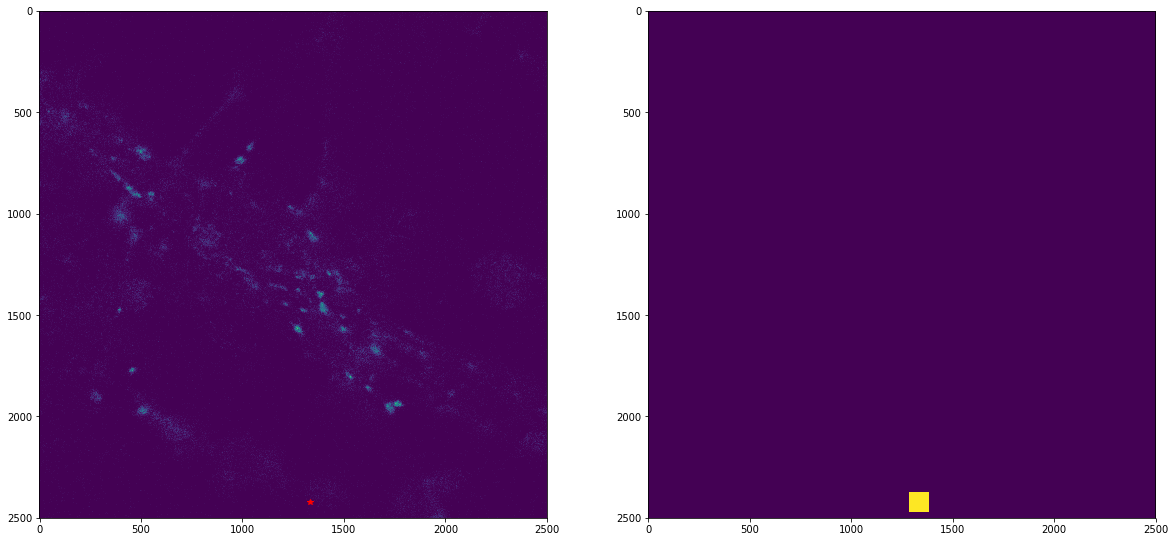

In [13]:
fig=plt.figure(figsize=(20,20))
fig.add_subplot(121)
plt.imshow(synapse_image)
plt.plot(center_of_spot[1],center_of_spot[0],'*r')
synapse_copy=deepcopy(synapse_image)
if ((center_of_spot[1]-50>0) & (center_of_spot[1]+50>0)&(center_of_spot[0]-50>0) & (center_of_spot[0]+50>0)):
    synapse_copy[center_of_spot[0]-50:center_of_spot[0]+50,
             center_of_spot[1]-50:center_of_spot[1]+50]=100
synapse_copy[synapse_copy<100]=0
fig.add_subplot(122)
plt.imshow(synapse_copy)

## Dataframe

In [14]:
df=pd.DataFrame(ecm_distribution_around_synapses)

## Plot a random spots image

size of synapse: 


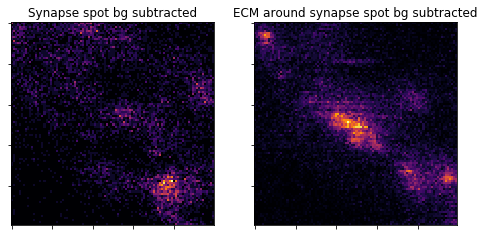

In [15]:
randomno=np.random.randint(1,len(df))
fig=plt.figure(figsize=(8,4))
fig.add_subplot(121)
plt.imshow(df["original_synapse_at_single_spot"][randomno],cmap='inferno')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.gca().set(aspect='equal',adjustable='box')
plt.grid(False)
plt.title('Synapse spot bg subtracted')
fig.add_subplot(122)
plt.imshow(df["ecm_around_single_spot"][randomno],cmap='inferno')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.gca().set(aspect='equal',adjustable='box')
plt.grid(False)
plt.title('ECM around synapse spot bg subtracted')

print('size of synapse: '+str())

## Add radial average

In [16]:
## radial_average version 2
def radial_average(image):
    import numpy as np
    import scipy
    from scipy import ndimage
    import matplotlib.pyplot as plt
    f = image
    sx, sy = f.shape
    X, Y = np.ogrid[0:sx, 0:sy]
    r = np.hypot(X - sx/2, Y - sy/2)
    rbin = (20* r/r.max()).astype(np.int) ##30 rings --> r-
    radial_mean = ndimage.mean(f, labels=rbin, index=np.arange(1, rbin.max() +1))
    return radial_mean

## Add meaningful columns to the dataframe

In [17]:
#make df, which also contains column names for plotting (drug, condition)
df['Time']='None'
df.loc[df['filename'].str.contains('Ctrl'), 'Time'] = 'Unblocked Control'
df.loc[df['filename'].str.contains('Unblocked'), 'Time'] = 'Unblocked Control'
df.loc[df["filename"].str.contains('12hr'), 'Time'] = '12hrs'

df.loc[df['filename'].str.contains('Bic'), 'Drug'] = 'Bic'
df.loc[df['filename'].str.contains('DMSO'), 'Drug'] = 'DMSO'
df.loc[df['filename'].str.contains('Ctrl'), 'Drug'] = 'DMSO'
df.loc[df['filename'].str.contains('Unblocked'), 'Drug'] = 'DMSO'

#nicely written treatment condition for plotting
df['Condition']='None'
df.loc[df['filename'].str.contains('12hrs_Bic'), 'Condition'] = '12hr + Bic'
df.loc[df['filename'].str.contains('12hrs_DMSO'), 'Condition'] = '12hr + DMSO'
df.loc[df['filename'].str.contains('Ctrl'), 'Condition'] = 'Unblocked Control'
df.loc[df['filename'].str.contains('Unblocked'), 'Condition'] = 'Unblocked Control'

df["expname"]='None'
df.loc[df['filename'].str.contains('20190216'), 'expname'] = '20190216_TNR580_DiO_VGlut647'
df.loc[df['filename'].str.contains('20190225'), 'expname'] = '20190225_TNR647_VGlut580_DiO'
df.loc[df['filename'].str.contains('20190302'), 'expname'] = '20190302_TNR647_Vglut580_DiO'
df.loc[df['filename'].str.contains('20190307'), 'expname'] = '20190307_TNR647_VGlut580_DiO_analyse'

In [18]:
df2=deepcopy(df[df["Time"]=="12hrs"])
df2=df2.reset_index()
df2["ecm mean int norm2med"]=df2["ecm_around_single_spot_mean_intensity bg subtracted"]
df2["vglut mean int norm2med"]=df2["mean_intensty_original_synapse bg subtracted"]

In [19]:
df2.head()

,index,filename,exp condition,ecm_around_single_spot,ecm_around_single_spot_mean_intensity,ecm_around_single_spot bg subtracted,ecm_around_single_spot_mean_intensity bg subtracted,original_synapse_at_single_spot,mean_intensty_original_synapse,original_synapse_at_single_spot bg subtracted,mean_intensty_original_synapse bg subtracted,synapse size - no pixels in mask,Time,Drug,Condition,expname,ecm mean int norm2med,vglut mean int norm2med
0,0,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/F...,12hr_Bic,"[[1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...",1.1331,"[[0.00032235294117647067, 0.0, 0.0003223529411...",0.002369,"[[1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,...",3.8839,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.007781,332.0,12hrs,Bic,None,20190216_TNR580_DiO_VGlut647,0.002369,0.007781
1,1,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/F...,12hr_Bic,"[[4, 1, 4, 1, 2, 1, 0, 3, 3, 4, 2, 1, 0, 3, 2,...",1.7164,"[[0.00964, 0.0, 0.00964, 0.0, 0.00179686274509...",0.002778,"[[1, 1, 0, 0, 0, 1, 1, 0, 1, 2, 1, 0, 2, 0, 2,...",7.0047,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.011192,906.0,12hrs,Bic,None,20190216_TNR580_DiO_VGlut647,0.002778,0.011192
2,2,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/F...,12hr_Bic,"[[3, 3, 1, 1, 2, 1, 1, 1, 2, 2, 1, 0, 1, 0, 1,...",0.9963,"[[0.008645490196078432, 0.008645490196078432, ...",0.002079,"[[1, 0, 3, 4, 5, 3, 7, 6, 1, 1, 5, 6, 3, 3, 2,...",5.1753,"[[0.0, 0.0, 0.0, 0.0, 0.00034745098039215896, ...",0.010400,558.0,12hrs,Bic,None,20190216_TNR580_DiO_VGlut647,0.002079,0.010400
3,3,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/F...,12hr_Bic,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,...",1.7746,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.003205,"[[0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,...",5.5177,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.009680,533.0,12hrs,Bic,None,20190216_TNR580_DiO_VGlut647,0.003205,0.009680
4,4,/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/F...,12hr_Bic,"[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.8922,"[[0.0, 0.0, 0.0012623529411764705, 0.0, 0.0, 0...",0.002296,"[[0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1,...",7.4986,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.014143,1274.0,12hrs,Bic,None,20190216_TNR580_DiO_VGlut647,0.002296,0.014143


In [20]:
expnam=[]
medtnr=[]
medvglut=[]
for exp in df2["expname"].unique():
    dfexp=df2[df2["expname"]==exp]
    med_tnr=dfexp["ecm_around_single_spot_mean_intensity bg subtracted"].median()
    med_vglut=dfexp["mean_intensty_original_synapse bg subtracted"].median()
    print(exp+' - med tnr: '+str(med_tnr)+' - med vglut: '+str(med_vglut))
    expnam.append(exp)
    medtnr.append(med_tnr)
    medvglut.append(med_vglut)
df2["ecm mean int norm2med"]=np.nan
df2["vglut mean int norm2med"]=np.nan
for i in range(0,len(df2)):
    if df2["expname"][i]==expnam[0]:
        df2["ecm mean int norm2med"][i]=df2["ecm_around_single_spot_mean_intensity bg subtracted"][i]/medtnr[0]
        df2["vglut mean int norm2med"][i]=df2["mean_intensty_original_synapse bg subtracted"][i]/medvglut[0]
    if df2["expname"][i]==expnam[1]:
        df2["ecm mean int norm2med"][i]=df2["ecm_around_single_spot_mean_intensity bg subtracted"][i]/medtnr[1]
        df2["vglut mean int norm2med"][i]=df2["mean_intensty_original_synapse bg subtracted"][i]/medvglut[1]
    if df2["expname"][i]==expnam[2]:
        df2["ecm mean int norm2med"][i]=df2["ecm_around_single_spot_mean_intensity bg subtracted"][i]/medtnr[2]
        df2["vglut mean int norm2med"][i]=df2["mean_intensty_original_synapse bg subtracted"][i]/medvglut[2]
    if df2["expname"][i]==expnam[3]:
        df2["ecm mean int norm2med"][i]=df2["ecm_around_single_spot_mean_intensity bg subtracted"][i]/medtnr[3]
        df2["vglut mean int norm2med"][i]=df2["mean_intensty_original_synapse bg subtracted"][i]/medvglut[3]

20190216_TNR580_DiO_VGlut647 - med tnr: 0.0025646709411764703 - med vglut: 0.01029187388235294
20190225_TNR647_VGlut580_DiO - med tnr: 0.009824618039215685 - med vglut: 0.008249767450980394
20190302_TNR647_Vglut580_DiO - med tnr: 0.005663376549019608 - med vglut: 0.0028133346862745097
20190307_TNR647_VGlut580_DiO_analyse - med tnr: 0.009070523137254902 - med vglut: 0.005635296764705882


/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.p

In [21]:
df2["expname"].unique()

array(['20190216_TNR580_DiO_VGlut647', '20190225_TNR647_VGlut580_DiO',
       '20190302_TNR647_Vglut580_DiO',
       '20190307_TNR647_VGlut580_DiO_analyse'], dtype=object)

In [22]:
dfbackup=deepcopy(df2)

In [23]:
df2=df2[df2["ecm mean int norm2med"]<
               df2["ecm mean int norm2med"].quantile(.99)]
df2=df2[df2["vglut mean int norm2med"]<
               df2["vglut mean int norm2med"].quantile(.99)]

## Store to pkl or load from pkl

In [ ]:
expdir

In [ ]:
df2.to_pickle(expdir+'20190801_TNR_vglut_corr_df2.pkl')

In [4]:
df2=pd.read_pickle(expdir+'20190801_TNR_vglut_corr_df2.pkl')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/taldankovich/anaconda3/lib/python3.7/site-packages/pandas/io/pickle.py", line 166, in try_read
    return read_wrapper(lambda f: pkl.load(f))
  File "/Users/taldankovich/anaconda3/lib/python3.7/site-packages/pandas/io/pickle.py", line 148, in read_wrapper
    return func(f)
  File "/Users/taldankovich/anaconda3/lib/python3.7/site-packages/pandas/io/pickle.py", line 166, in <lambda>
    return read_wrapper(lambda f: pkl.load(f))
_pickle.UnpicklingError: invalid load key, '\x00'.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/taldankovich/anaconda3/lib/python3.7/site-packages/pandas/io/pickle.py", line 148, in read_wrapper
    return func(f)
  File "/Users/taldankovich/anaconda3/lib/python3.7/site-packages/pandas/io/pickle.py", line 173, in <lambda>
    lambda f: pc.load(f, encoding=encoding, compat=False))
  File "/Users/taldankovich/anaconda3/lib/python3.7/site-pac

TypeError: can only concatenate str (not "list") to str

## Correlate vGlut intensity to TNR intensity - all spots together

### scatterplot: each point = one spot, x= TNR mean intensity, y=vGlut mean intensity

<Figure size 432x288 with 0 Axes>

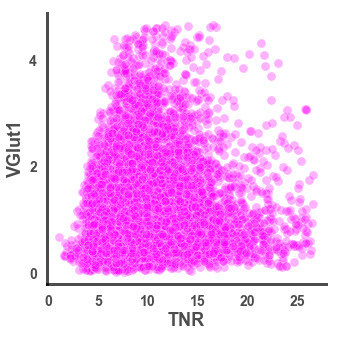

In [24]:
from matplotlib import ticker
sns.set(font_scale=2.5)
sns.set(font="Arial")
sns.set_style("white")
sns.despine()
sns.set_palette("Set2")

fig=plt.figure(figsize=(5,5))
g=sns.scatterplot(x="ecm mean int norm2med",
                  y="vglut mean int norm2med",data=df2,
               color="magenta",alpha=0.3,s=80)
#g.set_xscale('log')
plt.title('')
plt.locator_params(axis='y', nbins=5)
plt.yticks(visible=True,weight='bold',color='black',alpha=.7,fontsize=14)
plt.xticks(visible=True,weight='bold',color='black',alpha=.7,fontsize=14)


g.tick_params(width=3,color='black')
#g.set_ylabel('Fluorescence intensity (AU)',color='black',alpha=.7,labelpad=3,size=28,weight='bold')
g.set_ylabel('VGlut1',color='black',alpha=.7,fontsize=18,weight='bold')
g.set_xlabel('TNR',color='black',alpha=.7,fontsize=18,weight='bold')
g.grid(False)

sns.despine(ax=g,right=True,top=True)
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(3)
  g.spines[axis].set_color('black')
  g.spines[axis].set_alpha(.7)

scale_x=1/10
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
g.xaxis.set_major_formatter(ticks_x)



In [25]:
from pydoc import help
from scipy.stats.stats import pearsonr
pearsonr(df2["ecm mean int norm2med"],df2["vglut mean int norm2med"])


(0.027089011415805695, 0.011219543461224354)

<Figure size 432x288 with 0 Axes>

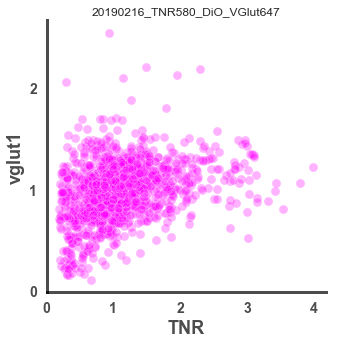

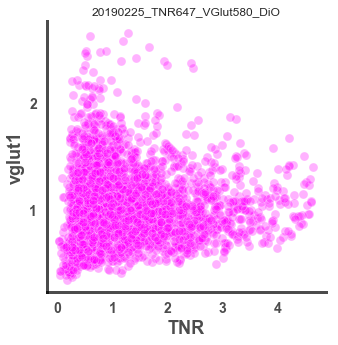

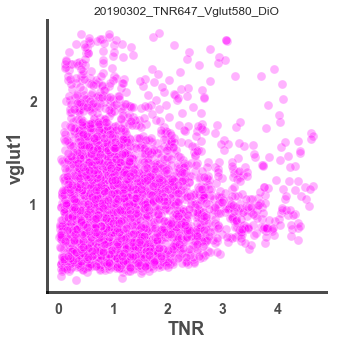

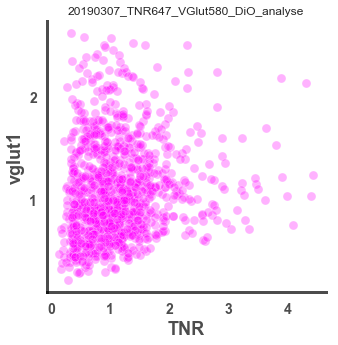

In [26]:
for exp in df["expname"].unique():
    df2plot=df2[df2["expname"]==exp]
    from matplotlib import ticker
    sns.set(font_scale=2.5)
    sns.set(font="Arial")
    sns.set_style("white")
    sns.despine()
    sns.set_palette("Set2")

    fig=plt.figure(figsize=(5,5))
    g=sns.scatterplot(x="vglut mean int norm2med",
                      y="ecm mean int norm2med",data=df2plot,
                   color="magenta",alpha=0.3,s=80)
    #g.set_xscale('log')
    plt.title('')
    plt.locator_params(axis='y', nbins=5)
    plt.yticks(visible=True,weight='bold',color='black',alpha=.7,fontsize=14)
    plt.xticks(visible=True,weight='bold',color='black',alpha=.7,fontsize=14)


    g.tick_params(width=3,color='black')
    #g.set_ylabel('Fluorescence intensity (AU)',color='black',alpha=.7,labelpad=3,size=28,weight='bold')
    g.set_ylabel('vglut1',color='black',alpha=.7,fontsize=18,weight='bold')
    g.set_xlabel('TNR',color='black',alpha=.7,fontsize=18,weight='bold')
    g.grid(False)

    sns.despine(ax=g,right=True,top=True)
    for axis in ['top','bottom','left','right']:
      g.spines[axis].set_linewidth(3)
      g.spines[axis].set_color('black')
      g.spines[axis].set_alpha(.7)

    #scale_x=1/10
    #ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
    #g.xaxis.set_major_formatter(ticks_x)
    plt.title(exp)





## Split into bins according to vglut intensity, look at average TNR intensity in each bin, for each exp separately

In [27]:
##sort df according to synapse intensity
df3=deepcopy(df2)
df3=df3.sort_values("vglut mean int norm2med",ascending=True)
df3=df3.reset_index(drop=True)
#split into 5 separate dfs, add column with number
a, b, c,d,e = np.split(df3, [int(.2*len(df3)),int(.4*len(df3)),int(.6*len(df3)),int(.8*len(df3))])
a['Synapse mean intensity ordinal bin']=0
b['Synapse mean intensity ordinal bin']=1
c['Synapse mean intensity ordinal bin']=2
d['Synapse mean intensity ordinal bin']=3
e['Synapse mean intensity ordinal bin']=4
#combine split dfs into one
dfnew=pd.concat([a,b,c,d,e],axis=0,ignore_index=True)

In [28]:
#synapse_bin_type="Synapse brightness scale (0 = dimmest)"
synapse_bin_type='Synapse mean intensity ordinal bin'

means_in_bins_exps={"Exp name":[],"bin number":[],"mean vglut":[],"mean tnr":[],"number of spots":[],
                    "mean vglut int in bin overall":[]}



for exp in dfnew["expname"].unique():
    dfexp=dfnew[dfnew["expname"]==exp]
    for i in range(0,5):
        
        mean_in_bin=dfnew[dfnew[synapse_bin_type].astype(int)==i]["vglut mean int norm2med"].mean()
        
        dfplot=dfexp[(dfexp[synapse_bin_type].astype(int)==i)&
                    (dfexp["Time"]!="Unblocked Control")]

        means_in_bins_exps["Exp name"].append(exp)
        means_in_bins_exps["bin number"].append(i)
        means_in_bins_exps["mean vglut int in bin overall"].append(mean_in_bin)
        means_in_bins_exps["mean vglut"].append(dfplot["vglut mean int norm2med"].mean())
        means_in_bins_exps["mean tnr"].append(dfplot["ecm mean int norm2med"].mean())
        nosynapses=len(dfplot)
        means_in_bins_exps["number of spots"].append(nosynapses)

In [29]:
dfmeans=pd.DataFrame(means_in_bins_exps)
dfmeans["mean vglut int in bin overall"]=np.around(dfmeans["mean vglut int in bin overall"],1)

<Figure size 432x288 with 0 Axes>

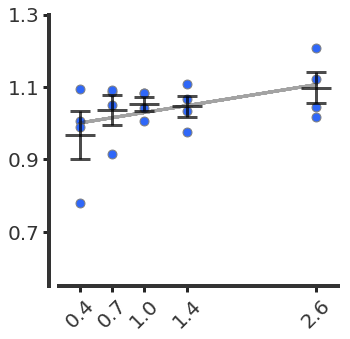

In [40]:
sns.set(font_scale=2.5)
sns.set(font="Arial")
sns.set_style("ticks")
sns.despine()
sns.set_palette("Set2")

#y="intensity normd 0 to 1"
var="mean tnr"
#y="intensity raw"
#y="raw intensity normd to dio mean"
fig=plt.figure(figsize=(5,5))
#order=['2hrs','4hrs','12hrs','No Blocking']
#palette ={"No Blocking":"gray","2hrs":"magenta","4hrs":"magenta","12hrs":"magenta"}


g=sns.scatterplot(x="mean vglut int in bin overall",y="mean tnr",
                data=dfmeans,s=80,color="#2F67F8",linewidth=1,edgecolor='grey')

'''g=sns.barplot(x="mean vglut int in bin overall",y="mean tnr",
                data=dfmeans,alpha=0.3,ci=None,color="#2F67F8")'''

# Make fake dataset
height = dfmeans.groupby("mean vglut int in bin overall")["mean tnr"].mean().values
 
# Choose the position of each barplots on the x-axis (space=1,4,3,1)
y_pos = dfmeans["mean vglut int in bin overall"].unique()
 
# Create bars
#plt.bar(y_pos, height)


def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        
        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        

#change_width(g, .7)

plt.errorbar(x = dfmeans["mean vglut int in bin overall"].unique()
,
             y=[dfmeans[dfmeans["bin number"]==0][var].mean(),
                dfmeans[dfmeans["bin number"]==1][var].mean(),
                dfmeans[dfmeans["bin number"]==2][var].mean(),
                dfmeans[dfmeans["bin number"]==3][var].mean(),
                dfmeans[dfmeans["bin number"]==4][var].mean()],
             yerr=[dfmeans[dfmeans["bin number"]==0][var].sem(),
                   dfmeans[dfmeans["bin number"]==1][var].sem(),
                   dfmeans[dfmeans["bin number"]==2][var].sem(),
                   dfmeans[dfmeans["bin number"]==3][var].sem(),
                   dfmeans[dfmeans["bin number"]==4][var].sem()],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,capthick=3,alpha=.7,)

plt.errorbar(x = dfmeans["mean vglut int in bin overall"].unique()
,
             y=[dfmeans[dfmeans["bin number"]==0][var].mean(),
                dfmeans[dfmeans["bin number"]==1][var].mean(),
                dfmeans[dfmeans["bin number"]==2][var].mean(),
                dfmeans[dfmeans["bin number"]==3][var].mean(),
                dfmeans[dfmeans["bin number"]==4][var].mean()],
             yerr=None,
             xerr=[.14,.14,.14,.14,.14],ecolor='black',fmt='none',capsize=0,linewidth=3,capthick=3,alpha=.7,)



#plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

g.grid(False)
plt.ylim([0.55,1.3])
plt.xlim([.2,2.8])


x1 = [dfmeans[dfmeans["bin number"]==bin]["mean vglut int in bin overall"] for bin in dfmeans["bin number"].unique()]
'''y = [dfmeans[dfmeans["bin number"]==0][var].mean(),
                dfmeans[dfmeans["bin number"]==1][var].mean(),
                dfmeans[dfmeans["bin number"]==2][var].mean(),
                dfmeans[dfmeans["bin number"]==3][var].mean(),
                dfmeans[dfmeans["bin number"]==4][var].mean()] # 10, not 9, so the fit isn't perfect
'''
x=dfmeans["mean vglut int in bin overall"]
y=dfmeans["mean tnr"]
m,b = np.polyfit(x, y, 1) 

plt.plot( x, m*x+b, 'k',linestyle='dashed',alpha=.4,linewidth=3) 

#plt.xticks(dfmeans["mean vglut int in bin overall"].unique(),size=18)

g.xaxis.set_tick_params(width=3)
g.yaxis.set_tick_params(width=3)

#plt.axhline(dfmeans[dfmeans["bin number"]==0][var].mean(),xmin=0.057,xmax=0.17, color='black',alpha=.7,linewidth=3)
#plt.axhline(dfmeans[dfmeans["bin number"]==1][var].mean(),xmin=0.15,xmax=0.3, color='black',alpha=.7,linewidth=3)
#plt.axhline(dfmeans[dfmeans["bin number"]==2][var].mean(),xmin=0.26,xmax=0.41, color='black',alpha=.7,linewidth=3)
#plt.axhline(dfmeans[dfmeans["bin number"]==3][var].mean(),xmin=0.42,xmax=0.59, color='black',alpha=.7,linewidth=3)
#plt.axhline(dfmeans[dfmeans["bin number"]==4][var].mean(),xmin=0.8,xmax=0.97, color='black',alpha=.7,linewidth=3)




for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)


offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":True,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=False,trim=False,offset=offsets)


#g.set_ylabel('TNR Normalised\nFluorescence intensity',
#             size=24,weight ='bold',labelpad=20,color='#333333')
#g.set_xlabel('vglut1 Normalised\nFluorescence intensity',
#             size=24,weight ='bold',labelpad=20,color='#333333')
g.set_ylabel('')
g.set_xlabel('')
plt.yticks([0.7,0.9,1.1,1.3],color='#333333',size=20)
plt.xticks([0.4, 0.7, 1. , 1.4, 2.6],color='#333333',size=20,rotation=45)




diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
fig.savefig(diri+'2b_tnrvglutcorr_option2.svg', bbox_inches='tight', format='svg')

In [ ]:
np.max(y)

In [31]:
from pydoc import help
from scipy.stats.stats import pearsonr
[pearson, pval]=pearsonr(dfmeans["mean tnr"],dfmeans["mean vglut int in bin overall"])
print(str(pearson**2))
print(pval)

0.18683685604721714
0.05699752965377453


In [32]:
pear**2

NameError: name 'pear' is not defined

In [ ]:
sns.set(font_scale=2.5)
sns.set(font="Arial")
sns.set_style("white")
sns.despine()
sns.set_palette("Set2")

#y="intensity normd 0 to 1"
var="mean tnr"
#y="intensity raw"
#y="raw intensity normd to dio mean"
plt.figure(figsize=(4,5))
#order=['2hrs','4hrs','12hrs','No Blocking']
#palette ={"No Blocking":"gray","2hrs":"magenta","4hrs":"magenta","12hrs":"magenta"}

'''g=sns.barplot(x="mean vglut int in bin overall",y="mean tnr",
                data=dfmeans,alpha=0.3,ci=None,color='magenta')

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        
        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        

change_width(g, .7)'''

g=sns.swarmplot(x="mean vglut int in bin overall",y="mean tnr",
                data=dfmeans,size=10,linewidth=1,hue="Exp name")

plt.errorbar(x=[0,1,2,3,4],
             y=[dfmeans[dfmeans["bin number"]==0][var].mean(),
                dfmeans[dfmeans["bin number"]==1][var].mean(),
                dfmeans[dfmeans["bin number"]==2][var].mean(),
                dfmeans[dfmeans["bin number"]==3][var].mean(),
                dfmeans[dfmeans["bin number"]==4][var].mean()],
             yerr=[dfmeans[dfmeans["bin number"]==0][var].sem(),
                   dfmeans[dfmeans["bin number"]==1][var].sem(),
                   dfmeans[dfmeans["bin number"]==2][var].sem(),
                   dfmeans[dfmeans["bin number"]==3][var].sem(),
                   dfmeans[dfmeans["bin number"]==4][var].sem()],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,capthick=3)

#g.hlines(dfmeans[dfmeans["bin number"]==0][var].mean(), xmin=-0.2, xmax=0.6, linewidth=3, color='magenta')
#g.hlines(dfmeans[dfmeans["bin number"]==1][var].mean(), xmin=-0.5, xmax=0.5, linewidth=3, color='magenta')
#g.hlines(dfmeans[dfmeans["bin number"]==2][var].mean(), xmin=-0.5, xmax=0.5, linewidth=3, color='magenta')
#g.hlines(dfmeans[dfmeans["bin number"]==3][var].mean(), xmin=-0.5, xmax=0.5, linewidth=3, color='magenta')
#g.hlines(dfmeans[dfmeans["bin number"]==4][var].mean(), xmin=-0.5, xmax=0.5, linewidth=3, color='magenta')



#scale_y=1/100
#ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
#g.yaxis.set_major_formatter(ticks_y)
g.set_ylabel('TNR Fluorescence intensity (AU)',size=14,weight ='bold',labelpad=20)
g.set_xlabel('vglut1 Fluorescence intensity (AU)',size=14,weight ='bold',labelpad=20)
plt.xticks(g.get_xticks(),size=16,rotation=45)
plt.yticks(g.get_yticks(),size=16)
g.grid(False)

sns.despine(ax=g,right=True,top=True)
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(3)
  g.spines[axis].set_color('black')
  g.spines[axis].set_alpha(.7)



x = np.arange(0,5,1)
y = [dfmeans[dfmeans["bin number"]==0][var].mean(),
                dfmeans[dfmeans["bin number"]==1][var].mean(),
                dfmeans[dfmeans["bin number"]==2][var].mean(),
                dfmeans[dfmeans["bin number"]==3][var].mean(),
                dfmeans[dfmeans["bin number"]==4][var].mean()] # 10, not 9, so the fit isn't perfect

m,b = np.polyfit(x, y, 1) 

plt.plot( x, m*x+b, '--k') 
g.get_legend().set_visible(False)

## Representative images

In [ ]:
binno=4


df2plot=dfnew[dfnew[synapse_bin_type].astype(int)==binno]
df2plot=df2plot.reset_index()


def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

fig=plt.figure(figsize=(5,400))
num=1
for i in range(200):
    randomno=np.random.randint(1,len(df2plot))
    ecm=df2plot["ecm_around_single_spot bg subtracted"][randomno]
    #ecm=rebin(ecm,[50,50])
    synapse=df2plot["original_synapse_at_single_spot bg subtracted"][randomno]
    #synapse=rebin(synapse,[50,50])
    name=df2plot["filename"][randomno]
    fig.add_subplot(200,2,num)
    plt.axis('off')
    
    plt.imshow(ecm,cmap='hot',
               vmin=0.95*np.min(dfnew["ecm_around_single_spot bg subtracted"].mean()),
               vmax=25*np.max(dfnew["ecm_around_single_spot bg subtracted"].mean()))
    scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)
    plt.axis('off')
    plt.ylabel('Bin: '+str(i))
    plt.title(randomno)
    fig.add_subplot(200,2,num+1)
    plt.imshow(synapse,
               cmap='viridis',
               vmin=0.95*np.min(dfnew["original_synapse_at_single_spot bg subtracted"].mean()),
               vmax=np.max(dfnew["original_synapse_at_single_spot bg subtracted"].mean()))
    numbersynapses=len(df2plot["original_synapse_at_single_spot bg subtracted"])
    

    scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':0,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)
    plt.axis('off')
    num+=2

In [ ]:
diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"


df2plot_bin0=dfnew[dfnew[synapse_bin_type].astype(int)==0]
df2plot_bin0=df2plot_bin0.reset_index()

df2plot_bin2=dfnew[dfnew[synapse_bin_type].astype(int)==2]
df2plot_bin2=df2plot_bin2.reset_index()

df2plot_bin4=dfnew[dfnew[synapse_bin_type].astype(int)==4]
df2plot_bin4=df2plot_bin4.reset_index()


spot_0=552 #8
spot_2=682 #549
spot_4=380# 849

spots=[spot_0,spot_2,spot_4]

vmin=0.003
vmax=0.04

vminsyn=0.004
vmaxsyn=0.075

count=1
for spot in spots:
    if count==1:
        df2plot=df2plot_bin0
    if count==2:
        df2plot=df2plot_bin2
    if count==3:
        df2plot=df2plot_bin4
    ecm=df2plot["ecm_around_single_spot bg subtracted"][spot]
    synapse=df2plot["original_synapse_at_single_spot bg subtracted"][spot]
    if count==2:
        ecm=np.rot90(ecm)
        synapse=np.rot90(synapse)
    fig_ecm=plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(ecm,cmap='gray',
               vmin=vmin,
               vmax=vmax)
    
    scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':0,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)
    
    plt.imsave(arr=ecm,cmap='gray',
               vmin=vmin,
               vmax=vmax,fname=diri+'2c_tnrsytcorr_ecm_bin_'+str(count)+'.tiff')
    
    
    fig_syn=plt.figure(figsize=(5,5))
    plt.imshow(synapse,
               cmap='gray',
               vmin=vminsyn,
               vmax=vmaxsyn)
    
    scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':0,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)
    plt.axis('off')
    plt.imsave(arr=synapse,cmap='gray',
               vmin=vmin,
               vmax=vmax,fname=diri+'2c_tnrsytcorr_syn_bin_'+str(count)+'.tiff')
    
    count+=1
    
    fig_ecm.savefig(diri+'2c_tnrsvglutcorr_ecm_bin_'+str(count)+'.png', bbox_inches='tight', format='png',pad_inches=0,
                   transparent = True)
    fig_syn.savefig(diri+'2c_tnrvglutcorr_syn_bin_'+str(count)+'.png', bbox_inches='tight', format='png',pad_inches=0,
                   transparent = True)




## choose spots to plot nicely

In [ ]:
diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"

import image

df2plot_bin0=dfnew[dfnew[synapse_bin_type].astype(int)==0]
df2plot_bin0=df2plot_bin0.reset_index()

df2plot_bin2=dfnew[dfnew[synapse_bin_type].astype(int)==2]
df2plot_bin2=df2plot_bin2.reset_index()

df2plot_bin4=dfnew[dfnew[synapse_bin_type].astype(int)==4]
df2plot_bin4=df2plot_bin4.reset_index()


spot_0=718#552 #8
spot_2=1571#682 #549
spot_4=1489# 849

spots=[spot_0,spot_2,spot_4]

vmin=0.003
vmax=0.04

vminsyn=0.004
vmaxsyn=0.075

count=1
for spot in spots:
    if count==1:
        df2plot=df2plot_bin0
    if count==2:
        df2plot=df2plot_bin2
    if count==3:
        df2plot=df2plot_bin4
    ecm=df2plot["ecm_around_single_spot bg subtracted"][spot]
    synapse=df2plot["original_synapse_at_single_spot bg subtracted"][spot]
    if count==2:
        ecm=np.rot90(ecm)
        synapse=np.rot90(synapse)
    fig_ecm=plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(ecm,cmap='gray',
               vmin=vmin,
               vmax=vmax)
    
    scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':0,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)
    
    plt.imsave(arr=ecm,cmap='gray',
               vmin=vmin,
               vmax=vmax,fname=diri+'2c_tnrvglutcorr_ecm_bin_'+str(count)+'.tiff')
    
    
    fig_syn=plt.figure(figsize=(5,5))
    plt.imshow(synapse,
               cmap='gray',
               vmin=vminsyn,
               vmax=vmaxsyn)
    
    scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':0,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)
    plt.axis('off')
    plt.imsave(arr=synapse,cmap='gray',
               vmin=vmin,
               vmax=vmax,fname=diri+'2c_tnrvglutcorr_syn_bin_'+str(count)+'.tiff')
    
    count+=1
    
    fig_ecm.savefig(diri+'2c_tnrvglutcorr_ecm_bin_'+str(count)+'.png', bbox_inches='tight', format='png',pad_inches=0,
                   transparent = True)
    fig_syn.savefig(diri+'2c_tnrvglutcorr_syn_bin_'+str(count)+'.png', bbox_inches='tight', format='png',pad_inches=0,
                   transparent = True)
    


